## What are these accounts tweeting about?  
## N-grams and topic modelling

In [39]:
import os
import re
import pprint
import sqlite3 as sql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from spacy.lang.en import English
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

np.random.seed(123)

In [3]:
eng_tweets = pd.read_pickle('../data/eng_tweets.p')
user_rt = pd.read_pickle('../data/user_rt.p')
user_original = pd.read_pickle('../data/user_rt.p')

#with sql.connect('../data/eng_tweets.db') as conn:
#    eng_tweets = pd.read_sql_query('select * from eng_tweets', conn)
eng_tweets.head()

,external_author_id,author,content,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,hashtags,mentions
0,906000000000000000,10_GOP,We have a sitting Democrat US Senator on trial...,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,[],[@nedryun]
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti Trump s...,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,[],[]
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0,905874659358453760,914623490375979008,[#BoycottNFL],[]
3,906000000000000000,10_GOP,JUST IN President Trump dedicates Presidents C...,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,[],[]
4,906000000000000000,10_GOP,19000 RESPECTING our National Anthem Stand For...,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0,905874659358453760,914312219952861184,[#StandForOurAnthem],[]


In [4]:
#user_original = pd.read_csv('../data/user_original.csv')
#user_rt = pd.read_csv('../data/user_rt.csv')

#with sql.connect('../data/user_original.db') as conn:
#    user_original = pd.read_sql_query('select * from user_original', conn)
user_original.head()

,author,account_category,content
0,10_GOP,RightTroll,Daughter of fallen Navy Sailor delivers powerf...
1,1D_NICOLE_,Fearmonger,Food Poisoning is not a joke Walmart Koch Farm...
2,1ERIK_LEE,RightTroll,Why is someone even against the petition I'll ...
3,4EVER_SUSAN,RightTroll,Raiders defense playing hungry Bending and not...
4,4MYSQUAD,LeftTroll,'politicalseason Maat Justice Injustice in Lou...


In [5]:
#with sql.connect('../data/user_rt.db') as conn:
#    user_rt = pd.read_sql_query('select * from user_rt', conn)
#user_rt.head()

In [6]:
targets = ['RightTroll', 'LeftTroll', 'Newsfeed']
eng_tweets = eng_tweets.loc[eng_tweets.account_category.isin(targets)]

In [7]:
#user_original = user_original[user_original.tweet_text != np.nan]
#user_rt = user_rt[user_rt.tweet_text != np.nan]

### N-grams

In [8]:
unigram_vect = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
bigram_vect = TfidfVectorizer(ngram_range=(2,2), stop_words='english')
trigram_vect = TfidfVectorizer(ngram_range=(3,3), stop_words='english')

### Top 10 words

In [45]:
eng_summaries = "".join(eng_tweets['content'])
eng_unigrams = unigram_vect.build_analyzer()(eng_summaries)

for value, count in Counter(eng_unigrams).most_common(10):
    print(value)

trump
black
just
hillary
people
obama
new
real
like
america


### Top 10 bigrams

In [44]:
#eng_summaries = "".join(eng_tweets['content'])
eng_bigrams = bigram_vect.build_analyzer()(eng_summaries)

for value, count in Counter(eng_bigrams).most_common(10):
    print(value)

donald trump
real donald
lives matter
black lives
hillary clinton
fox news
president trump
white house
fake news
north korea


### Top 10 trigrams

In [43]:
eng_summaries = "".join(eng_tweets['content'])
eng_trigrams = trigram_vect.build_analyzer()(eng_summaries)

#Counter(eng_trigrams).most_common(10)
for value, count in Counter(eng_trigrams).most_common(10):
    print(value)

real donald trump
black lives matter
cnn fakenews cnn
fakenews cnn fakenews
make america great
john mc cain
archived hedge bz
enlist patriot army
black history month
curated hedge bz


### Topic Modelling

In [15]:
len(user_original.author.value_counts())

1019

In [16]:
import gensim
import nltk
import pyLDAvis.gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

np.random.seed(123)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gcdunn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gcdunn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [18]:
en_stop.add('the')
en_stop.add('amp')

In [19]:
stemmer = SnowballStemmer('english')

In [20]:
def lemma_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text, lemmatize=False):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if lemmatize == True:
                result.append(lemma_stem(token))
            else:
                result.append(token)
    return result

In [47]:
eng_tweets['processed'] = eng_tweets.apply(lambda row: preprocess(row['content'].lower()), axis=1)
#user_original['processed'] = user_original.apply(lambda row: preprocess(row['content'].lower()), axis=1)
#user_rt['processed'] = user_rt.apply(lambda row: preprocess(row['content'].lower()), axis=1)

In [48]:
user_original.processed.head()

0    [daughter, fallen, navy, sailor, delivers, pow...
1    [food, poisoning, joke, walmart, koch, farms, ...
2    [petition, watch, bleeding, thug, shoots, guns...
3    [raiders, defense, playing, hungry, bending, b...
4    [politicalseason, maat, justice, injustice, lo...
Name: processed, dtype: object

In [49]:
#user_original['tokenized'] = user_original.apply(lambda row: nltk.word_tokenize(row['content'].lower()), axis=1)
#user_rt['tokenized'] = user_rt.apply(lambda row: nltk.word_tokenize(row['content'].lower()), axis=1)

In [50]:
#user_original['tokenized'] = user_original.tokenized.apply(lambda x: [item for item in x if item not in en_stop])
#user_rt['tokenized'] = user_rt.tokenized.apply(lambda x: [item for item in x if item not in en_stop])

In [51]:
#user_original['tokenized'] = user_original.tokenized.apply(lambda x: [item for item in x if len(item) > 2])
#user_rt['tokenized'] = user_rt.tokenized.apply(lambda x: [item for item in x if len(item) > 2])

In [52]:
dictionary = corpora.Dictionary(eng_tweets['processed'])
corpus = [dictionary.doc2bow(text) for text in eng_tweets['processed']]

In [79]:
ntopics = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.068*"black" + 0.028*"lives" + 0.027*"matter" + 0.027*"police" + 0.022*"people"')
(1, '0.026*"pjnet" + 0.013*"happy" + 0.012*"playing" + 0.011*"gopdebate" + 0.010*"music"')
(2, '0.024*"breaking" + 0.011*"dems" + 0.011*"left" + 0.010*"free" + 0.010*"liberal"')
(3, '0.010*"guns" + 0.009*"twitter" + 0.009*"city" + 0.008*"control" + 0.008*"freedom"')
(4, '0.012*"cruz" + 0.010*"wall" + 0.008*"words" + 0.008*"hell" + 0.008*"health"')
(5, '0.019*"love" + 0.018*"know" + 0.017*"like" + 0.017*"think" + 0.016*"debate"')
(6, '0.018*"muslims" + 0.013*"democrats" + 0.010*"rally" + 0.010*"muslim" + 0.009*"liberals"')
(7, '0.037*"tcot" + 0.023*"news" + 0.012*"post" + 0.011*"isis" + 0.010*"best"')
(8, '0.018*"american" + 0.017*"america" + 0.016*"people" + 0.014*"wake" + 0.012*"time"')
(9, '0.124*"trump" + 0.049*"hillary" + 0.033*"donald" + 0.030*"real" + 0.026*"obama"')


In [ ]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [29]:
#dictionary = corpora.Dictionary(user_rt['processed'])
#corpus = [dictionary.doc2bow(text) for text in user_rt['processed']]

In [76]:
#ntopics = 4
#ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15)
#ldamodel.save('model.gensim')
#topics = ldamodel.print_topics(num_words=5)
#for topic in topics:
#    print(topic)

In [77]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)

In [ ]:
# the vectorizer object will be used to transform text to vector form
# reject tokens in more than 90% or less than 25% of documents
#vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
#tf = vectorizer.fit_transform(user_original['content']).toarray()

# tf_feature_names tells us what word each column in the matrix represents
#tf_feature_names = vectorizer.get_feature_names()

In [ ]:
#number_of_topics = 10

#model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [ ]:
#model.fit(tf)

## Hashtag correlation matrix: Are pairs of hashtags strongly correlated or anti-correlated?

In [58]:
# select only observations where the hashtag list is not empty
targets = ['RightTroll', 'LeftTroll']
hashtag_df = pd.DataFrame(eng_tweets.hashtags[(eng_tweets.hashtags.apply(
    lambda hashtags_list: hashtags_list !=[])) & (eng_tweets.account_category.isin(targets))])

In [59]:
hashtag_df.head()

,hashtags
2,[#BoycottNFL]
4,[#StandForOurAnthem]
24,[#HipHopAwards]
43,[#Iran]
46,[#MAGA]


In [60]:
flattened_hashtags = hashtag_df.hashtags.tolist()
flattened_hashtags = pd.DataFrame([item for sublist in flattened_hashtags for item in sublist], columns=['hashtag'])
flattened_hashtags.hashtag = flattened_hashtags.hashtag.str.upper()

#flattened_hashtags.hashtag = flattened_hashtags.hashtag.str.lower()
flattened_hashtags.head()

,hashtag
0,#BOYCOTTNFL
1,#STANDFOROURANTHEM
2,#HIPHOPAWARDS
3,#IRAN
4,#MAGA


In [61]:
# number of unique hashtags
flattened_hashtags.hashtag.unique().size

79143

In [62]:
# count of appearances of each hashtag
popular_hashtags = (flattened_hashtags.groupby('hashtag').size().reset_index(name='counts')
                                        .sort_values('counts', ascending=False)
                                        .reset_index(drop=True))
popular_hashtags.head()

,hashtag,counts
0,#TCOT,14628
1,#MAGA,13034
2,#PJNET,12392
3,#BLACKLIVESMATTER,12298
4,#NEWS,8666


In [63]:
# take hashtags which appear at least this amount of times
min_appearance = 2000
# find popular hashtags - make into python set for efficiency

popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag'])
#popular_hashtags_set

In [64]:
len(popular_hashtags_set)

34

In [65]:
# make a new column with only the popular hashtags
flattened_hashtags['popular'] = flattened_hashtags.hashtag.isin(popular_hashtags_set)
flattened_hashtags.head()

,hashtag,popular
0,#BOYCOTTNFL,False
1,#STANDFOROURANTHEM,False
2,#HIPHOPAWARDS,False
3,#IRAN,False
4,#MAGA,True


In [66]:
# drop rows without popular hashtag
popular_hashtags = flattened_hashtags.loc[flattened_hashtags.popular==True]

In [67]:
popular_hashtags.head()

,hashtag,popular
4,#MAGA,True
20,#MAGA,True
103,#TRUMPTRAIN,True
126,#GOPDEBATE,True
127,#VEGASGOPDEBATE,True


In [68]:
# make a new column with only the popular hashtags
hashtag_df['popular_hashtags'] = hashtag_df.hashtags.apply(lambda hashtag_list: 
                                                           [hashtag for hashtag in str(hashtag_list).lower() 
                                                            if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtag_df.loc[
            hashtag_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list != [])]

In [69]:
unique_popular_ht = pd.DataFrame(popular_hashtags.hashtag.value_counts())
unique_popular_ht = unique_popular_ht.reset_index()
unique_popular_ht.columns = ['hashtag','count']

In [70]:
## make new dataframe
hashtag_vector_df = unique_popular_ht.loc[:, ['hashtag']]

In [71]:
for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.hashtag.apply(lambda hashtag_list: int(set(hashtag).issubset(hashtag_list)))

In [72]:
#drop the row labels
hashtag_matrix = hashtag_vector_df.drop('hashtag', axis=1)

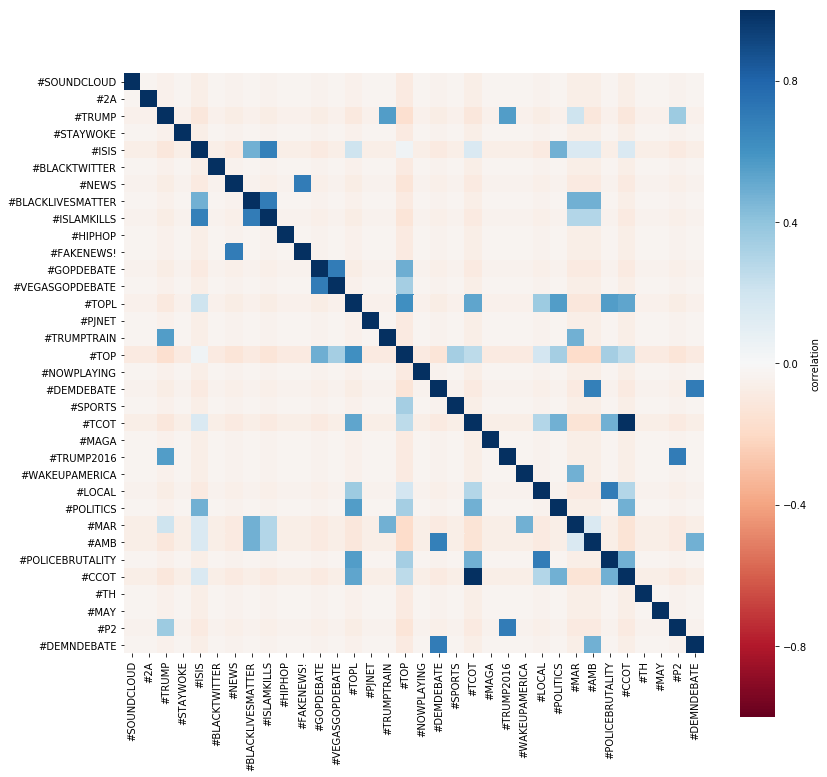

In [75]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(13,13))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
#plt.xticks(rotation=45)
plt.show()